In [1]:
import pandas as pd
import io
from langdetect import detect
import nltk
import re
import unicodedata
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
def load_word_lists():
    """Carga los diccionarios de palabras"""
    
    word_lists = {
        'polite_words': {
            "es": ["gracias", "por favor", "buen dia", "seria tan amable", "le agradezco", "disculpe", "permítame"],
            "en": ["please", "thank you", "good morning", "kindly", "appreciate", "sorry", "excuse me"]
        },
        'rude_words': {
            "es": ["maldito", "idiota", "estúpido", "imbécil", "pendejo", "culero", "pinche"],
            "en": ["stupid", "idiot", "dumb", "useless", "shit", "terrible", "lazy", "damn"]
        },
        'technical_terms': {
            "es": ["sistema", "base de datos", "protocolo", "infraestructura", "algoritmo", "interfaz", "servidor"],
            "en": ["system", "database", "protocol", "infrastructure", "algorithm", "interface", "server"]
        },
        'toxic_words': {
            "es": ["tonto", "idiota", "estúpido", "imbécil", "maldito", "horrible", "perezoso"],
            "en": ["stupid", "idiot", "dumb", "useless", "shit", "terrible", "lazy"]
        },
        'desagrado': {
            "es": ["no me gusta", "malo", "pésimo", "desagradable", "asco", "horror", "feo", "fatal", 
                   "terrible", "decepcionante", "guácala", "fuchi", "repugnante", "rechazo"],
            "en": ["dislike", "bad", "terrible", "gross", "disgusting", "awful", "nasty", "poor quality", 
                   "yuck", "revolting", "hate it", "displeased", "unpleasant"]
        },
        'frustracion': {
            "es": ["intentar", "otra vez", "de nuevo", "no funciona", "bloqueado", "harto", "impotencia", 
                   "siempre lo mismo", "fallo", "error", "espera", "inútil", "incapaz"],
            "en": ["tried", "again", "still not", "stuck", "fed up", "failure", "broken", "useless", 
                   "waiting", "blocked", "annoyed", "pointless", "keep trying"]
        },
        'gratitud': {
            "es": ["gracias", "agradezco", "buenísimo", "excelente", "amable", "bendiciones", "genial", 
                   "ayudó mucho", "recomiendo", "valoro", "perfecto"],
            "en": ["thanks", "thank you", "grateful", "appreciate", "kind", "helpful", "awesome", 
                   "perfect", "blessed", "highly recommend", "supportive"]
        },
        'indiferencia': {
            "es": ["da igual", "equis", "me da lo mismo", "como sea", "no importa", "ni fu ni fa", 
                   "meh", "ok", "está bien", "sin opinión"],
            "en": ["whatever", "doesn't matter", "don't care", "anyway", "meh", "ok", "fine", 
                   "neutral", "indifferent", "as you wish", "regardless"]
        },
        'satisfaccion': {
            "es": ["contento", "feliz", "valió la pena", "logré", "funciona", "bien", "satisfecho", 
                   "gusto", "maravilla", "increíble", "justo lo que quería"],
            "en": ["happy", "satisfied", "pleased", "works", "worth it", "glad", "great", 
                   "fulfilled", "exactly", "success", "delighted"]
        },
        'rabia_ira': {
            "es": ["enojado", "furia", "basura", "estafa", "robo", "insoportable", "maldito", 
                   "odio", "indignado", "insulto", "inservible", "peor", "asco de"],
            "en": ["angry", "mad", "hate", "scam", "shameful", "outraged", "furious", "garbage", 
                   "trash", "disgrace", "infuriating", "pissed", "worst"]
        },
        'amenazas': {
            "es": ["demandar", "denuncia", "PROFECO", "legal", "abogado", "ir de la competencia", 
                   "cancelar", "baja", "quemar", "nunca más", "redes sociales", "última vez"],
            "en": ["sue", "legal action", "lawyer", "reporting", "cancel", "switching to", 
                   "never again", "last warning", "publicly", "court", "quit"]
        }
    }
    
    return word_lists

def normalize_text(text):
    """Normaliza el texto removiendo acentos"""
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize("NFD", text)
    text = "".join(c for c in text if unicodedata.category(c) != "Mn")
    return text.lower()

def detect_language_safe(text):
    """Detecta el idioma del texto de forma segura"""
    try:
        if pd.isna(text) or not isinstance(text, str) or len(text.strip()) < 3:
            return 'es'
        lang = detect(text)
        return lang if lang in ['es', 'en'] else 'es'
    except:
        return 'es'

def count_words_in_text(text, word_list, lang):
    """Cuenta cuántas palabras de una lista específica aparecen en el texto"""
    if pd.isna(text) or not isinstance(text, str):
        return 0
    
    text_normalized = normalize_text(text)
    words_from_dict = word_list.get(lang, [])
    
    count = 0
    for word in words_from_dict:
        word_normalized = normalize_text(word)
        pattern = r"\b" + re.escape(word_normalized) + r"\b"
        if re.search(pattern, text_normalized, re.IGNORECASE):
            count += 1
    
    return count

def analyze_sentiment_dataframe(df, text_column, word_lists=None):
    """
    Analiza sentimientos en un DataFrame.
    """
    
    # Crear una copia del DataFrame
    df_result = df.copy()
    
    # Detectar idioma para cada fila
    # progress_bar = st.progress(0, text="Detectando idiomas...")
    
    df_result['_lang_temp'] = df_result[text_column].apply(
        lambda x: detect_language_safe(str(x)) if pd.notna(x) else 'es'
    )
    # progress_bar.progress(10, text="Idiomas detectados")
    
    # Inicializar las 11 columnas nuevas
    # progress_bar.progress(15, text="Inicializando columnas...")
    # df_result['polite_words'] = 0
    # df_result['rude_words'] = 0
    # df_result['technical_terms'] = 0
    # df_result['toxic_words'] = 0
    # df_result['desagrado'] = 0
    # df_result['frustracion'] = 0
    # df_result['gratitud'] = 0
    # df_result['indiferencia'] = 0
    # df_result['satisfaccion'] = 0
    # df_result['rabia_ira'] = 0
    # df_result['amenazas'] = 0
    
    df_result["Sentimiento_Final"] = 0

    # Procesar cada fila
    total_rows = len(df_result)
    
    # Definir categorías de sentimiento
    sentiment_categories = ['desagrado', 'frustracion', 'gratitud', 'indiferencia', 
                           'satisfaccion', 'rabia_ira', 'amenazas']
    
    for idx, row in df_result.iterrows():
        # Actualizar barra de progreso
        if idx % max(1, total_rows // 20) == 0:
            progress = 15 + int((idx / total_rows) * 80)
            # progress_bar.progress(progress, text=f"Procesando fila {idx + 1}/{total_rows}...")
        
        text = row[text_column]
        if pd.isna(text) or not isinstance(text, str):
            continue
        
        lang = row['_lang_temp']
        
        # Contar palabras en cada categoría de sentimiento
        sentiment_scores = {}
        for category in sentiment_categories:
            if category in word_lists:
                sentiment_scores[category] = count_words_in_text(text, word_lists[category], lang)
        
        # Determinar el sentimiento dominante
        if sentiment_scores:
            max_score = max(sentiment_scores.values())
            if max_score > 0:
                dominant_sentiment = max(sentiment_scores, key=sentiment_scores.get)
                df_result.at[idx, 'Sentimiento_Final'] = dominant_sentiment
            else:
                df_result.at[idx, 'Sentimiento_Final'] = 'neutro'
        else:
            df_result.at[idx, 'Sentimiento_Final'] = 'neutro'

    
    # Eliminar columna temporal de idioma
    df_result = df_result.drop('_lang_temp', axis=1)
    
    # progress_bar.progress(100, text="✅ Procesamiento completado!")
    
    return df_result




In [3]:
df = pd.read_csv('./twitter_training.csv')
df.head(5)

,ID,LOB,SubLob,XD,Sentiment,Fecha
0,2401,C,X,Borderlands,im getting on borderlands and i will murder yo...,12/26/2025
1,2401,E,X,Borderlands,I am coming to the borders and I will kill you...,1/6/2025
2,2401,D,X,Borderlands,im getting on borderlands and i will kill you ...,5/13/2025
3,2401,E,X,Borderlands,im coming on borderlands and i will murder you...,3/24/2025
4,2401,A,Z,Borderlands,im getting on borderlands 2 and i will murder ...,3/16/2025


In [4]:
word_lists = load_word_lists()

In [5]:
df_resultado = analyze_sentiment_dataframe(
    df, 
    text_column='Sentiment',
    word_lists=word_lists)

/tmp/ipykernel_13582/3096310192.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'neutro' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_result.at[idx, 'Sentimiento_Final'] = 'neutro'


In [6]:
df_resultado.sort_values(by=['LOB', 'SubLob','XD'], inplace=True)
df_resultado.head(5)


,ID,LOB,SubLob,XD,Sentiment,Fecha,Sentimiento_Final
20,2404,A,X,Borderlands,that was the first borderlands session in a lo...,8/23/2025,neutro
28,2405,A,X,Borderlands,For the biggest male dissappoinment in my life...,7/14/2025,neutro
53,2409,A,X,Borderlands,all,11/17/2025,neutro
64,2411,A,X,Borderlands,.. [,2/22/2025,neutro
70,2412,A,X,Borderlands,Going to finish finish cleaning up Borderlands...,9/23/2025,neutro


In [7]:
# df_resultado.to_csv('./twitter_training_con_sentimientos.csv', index=False)

In [8]:
df_resultado['Sentimiento_Final'].value_counts()

Sentimiento_Final
neutro          2692
gratitud         204
satisfaccion     173
frustracion      160
rabia_ira         92
desagrado         89
indiferencia      47
0                 25
amenazas           4
Name: count, dtype: int64

In [9]:
# df_pivot = df_resultado.groupby(['LOB', 'SubLob','XD','Sentimiento_Final']).
# df_pivot.head(10)   

In [10]:
df_resultado_2 = df_resultado[df_resultado['Sentimiento_Final'] != 'neutro']
df_resultado_2 = df_resultado_2[df_resultado_2['Sentimiento_Final'] != 0]
df_resultado_2['Sentimiento_Final'].value_counts()

Sentimiento_Final
gratitud        204
satisfaccion    173
frustracion     160
rabia_ira        92
desagrado        89
indiferencia     47
amenazas          4
Name: count, dtype: int64

In [11]:
def stacked_bar_plot_sentiment_by_lob(data,filtro_1,campo_sentimiento):
    """Crea un gráfico de barras apiladas mostrando el porcentaje de cada sentimiento por LOB."""
    
    # Preparar datos con porcentajes    
    df_grouped = data.groupby([filtro_1, campo_sentimiento]).size().unstack(fill_value=0)
    df_pct = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100

    # Crear gráfico de barras apiladas con porcentajes
    plt.figure(figsize=(12, 6))
    ax = df_pct.plot(kind='bar', stacked=True, ax=plt.gca())

    ax.set_title(f"Stacked Bar Plot of Sentiment by {filtro_1} (%)")
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel(filtro_1)
    ax.set_ylim(0, 100)

    # Agregar etiquetas de porcentaje
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

    plt.legend(title="Sentimiento_Final", bbox_to_anchor=(1, 1), loc="upper left")
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()

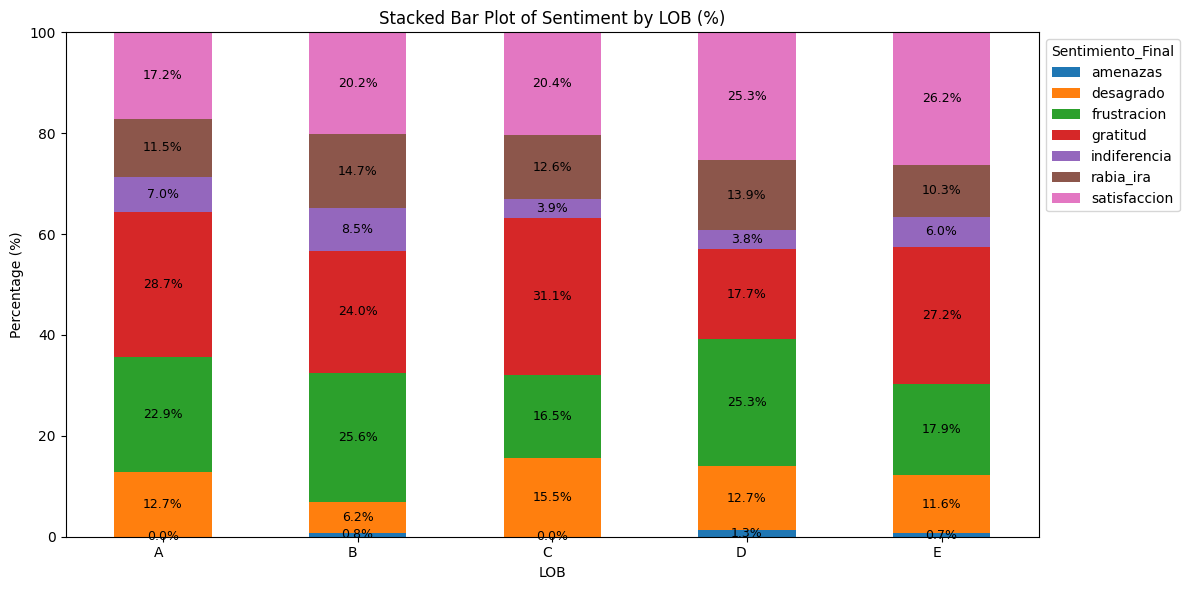

In [12]:
data = df_resultado_2
filtro_1 = 'LOB'
campo_sentimiento = 'Sentimiento_Final'
stacked_bar_plot_sentiment_by_lob(data,filtro_1,campo_sentimiento)

In [13]:
df_resultado_2.head(2)

,ID,LOB,SubLob,XD,Sentiment,Fecha,Sentimiento_Final
217,2437,A,X,Borderlands,@ Borderlands something seems very broken with...,11/1/2025,frustracion
220,2437,A,X,Borderlands,2 @Borderlands something seems very broken wit...,12/16/2025,frustracion


In [14]:
df_temporal = df_resultado_2.copy()
df_temporal['Fecha'] = pd.to_datetime(df_temporal['Fecha'], errors='coerce')
df_temporal = df_temporal.dropna(subset=['Fecha'])  
df_temporal = df_temporal.pivot_table(index='Fecha', columns='Sentimiento_Final', aggfunc='size', fill_value=0).reset_index().melt(id_vars='Fecha', var_name='Sentimiento_Final', value_name='counts')  
df_temporal.head(5)

,Fecha,Sentimiento_Final,counts
0,2025-01-02,amenazas,0
1,2025-01-04,amenazas,0
2,2025-01-05,amenazas,0
3,2025-01-06,amenazas,0
4,2025-01-07,amenazas,0


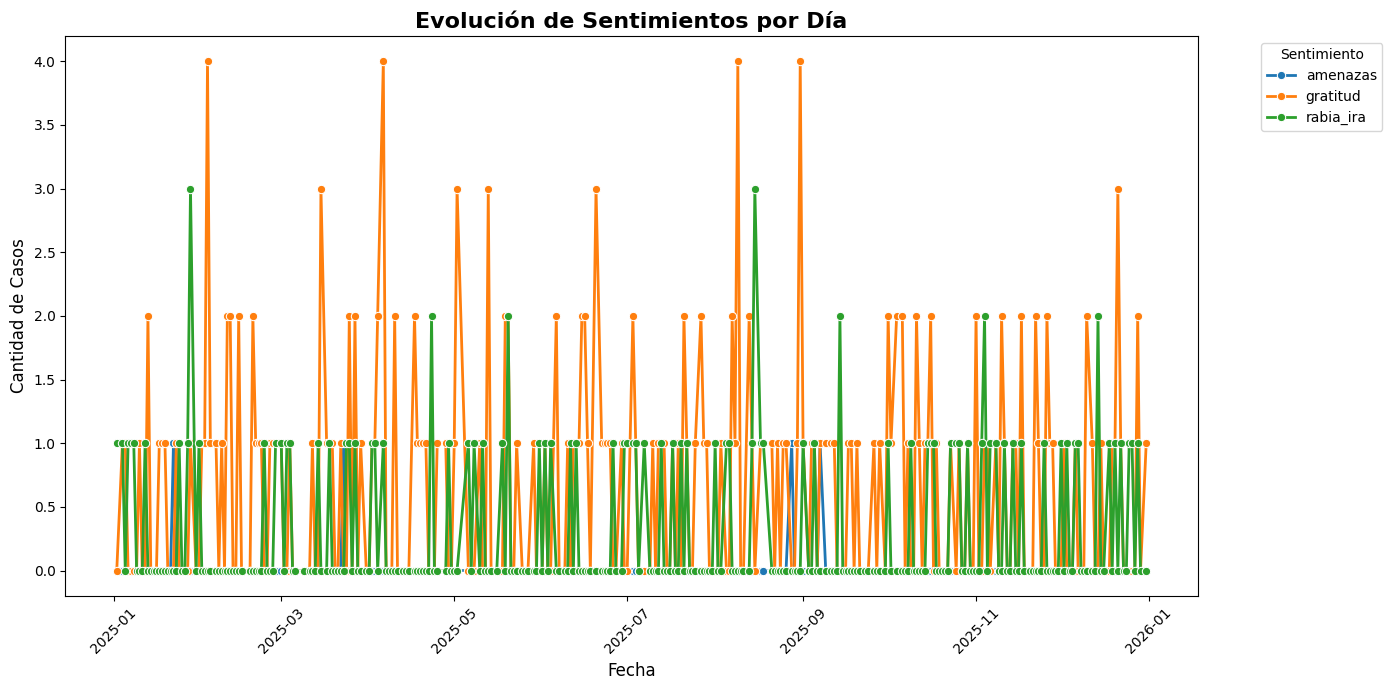

In [19]:
def plot_sentiment_evolution(data,campo_fecha,campo_sentimiento,sentimiento_filtro):
    data = df_resultado_2.copy()
    data['Fecha'] = pd.to_datetime(data[campo_fecha], errors='coerce')
    data = data.dropna(subset=[campo_fecha])  
    data = data.pivot_table(index='Fecha', columns=campo_sentimiento, aggfunc='size', fill_value=0).reset_index().melt(id_vars='Fecha', var_name='Sentimiento_Final', value_name='counts')  
    data = data[data['Sentimiento_Final'].isin(sentimiento_filtro)]
    
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=data, x='Fecha', y='counts', hue='Sentimiento_Final', marker='o', linewidth=2, markersize=6)
    plt.title('Evolución de Sentimientos por Día', fontsize=16, fontweight='bold')
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Cantidad de Casos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Sentimiento', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

data = df_temporal
campo_fecha = 'Fecha'
campo_sentimiento = 'Sentimiento_Final'
sentimiento_filtro = ['amenazas', 'rabia_ira', 'gratitud']
plot_sentiment_evolution(data,campo_fecha, campo_sentimiento, sentimiento_filtro)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from ipywidgets import interact, Dropdown

# # Preparar datos
# df_temporal = df_resultado_2.copy()
# df_temporal['Fecha'] = pd.to_datetime(df_temporal['Fecha'], errors='coerce')
# df_temporal = df_temporal.dropna(subset=['Fecha'])
# df_temporal = df_temporal.groupby(['Fecha','LOB','SubLob','Sentimiento_Final']).size().reset_index(name='counts')

# # Función para crear gráfica con filtros
# def grafica_sentimientos(LOB='Todos', SubLOB='Todos'):
#     # Filtrar datos
#     df_filtrado = df_temporal.copy()
    
#     if LOB != 'Todos':
#         df_filtrado = df_filtrado[df_filtrado['LOB'] == LOB]
    
#     if SubLOB != 'Todos':
#         df_filtrado = df_filtrado[df_filtrado['SubLob'] == SubLOB]
    
#     # Crear gráfica
#     plt.figure(figsize=(14, 7))
#     sns.lineplot(data=df_filtrado, x='Fecha', y='counts', hue='Sentimiento_Final',
#                  marker='o', linewidth=2.5, markersize=8, palette='Set2')
    
#     # Título dinámico
#     titulo = 'Evolución de Sentimientos por Día'
#     if LOB != 'Todos':
#         titulo += f' - LOB: {LOB}'
#     if SubLOB != 'Todos':
#         titulo += f' - SubLOB: {SubLOB}'
    
#     plt.title(titulo, fontsize=16, fontweight='bold', pad=20)
#     plt.xlabel('Fecha', fontsize=12)
#     plt.ylabel('Cantidad de Casos', fontsize=12)
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(title='Sentimiento', bbox_to_anchor=(1.05, 1), loc='upper left', 
#                frameon=True, shadow=True)
#     plt.grid(True, alpha=0.3, linestyle='--')
#     plt.tight_layout()
#     plt.show()

# # Obtener valores únicos para los filtros
# lobs = ['Todos'] + sorted(df_temporal['LOB'].unique().tolist())
# sublobs = ['Todos'] + sorted(df_temporal['SubLob'].unique().tolist())

# # Crear widgets interactivos
# interact(grafica_sentimientos, 
#          LOB=Dropdown(options=lobs, value='Todos', description='LOB:'),
#          SubLOB=Dropdown(options=sublobs, value='Todos', description='SubLOB:'))